In [29]:
import os
import matplotlib.pyplot as plt
import random
import shutil
import tensorflow as tf
from tensorflow import keras
import numpy as np
import itertools

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix

# Introduction

In this notebook we will use transfer learning, a method to use features learned on a large dataset and then fine tune the learned model on our particular problem, which is retinal images. 

The most common workflow for transfer learning is as follows :

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.


We choose Inception V3 as the trained model. 
But before we can start the workflow, we need to preprocess our images to be of the same size.Let's define some variables. 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BASE_IMG_PATH = '/content/drive/Othercomputers/My MacBook Pro/OCT2017'
LITE_IMG_PATH = os.path.join(BASE_IMG_PATH, 'light-set/')
BATCH_SIZE = 32
IMG_HEIGHT = 299 # match image dimensions to inceptionv3
IMG_WIDTH = 299  # match image dimensions to inceptionv3
SEED = 42
SAMPLE_SIZE = 250

# Count check

We will first check that the number of images for each class in the training set is correct.


In [ ]:
for subdir in os.listdir(os.path.join(BASE_IMG_PATH, 'train')):
    file_count = len(os.listdir(os.path.join(BASE_IMG_PATH, "train", subdir)))
    if subdir == 'NORMAL':
        assert file_count == 26312, 'NORMAL file count is incorrect'
    elif subdir == 'DME':
        assert file_count == 11343, 'DME file count is incorrect'
    elif subdir == 'CNV':
        assert file_count == 37202, 'CNV file count is incorrect'
    elif subdir == 'DRUSEN':
        assert file_count == 8602, 'DRUSEN file count is incorrect'
    else:
        pass

print('Training set is clean')

Training set is clean


# Sample Dataset

We will sample 250 images from each class. Let's defined 2 functions. 

In [22]:
def sample_classes(n: int=250):
    '''
    Samples n files from each class of the training dataset. 
    These samples are moved to another folder than contains the 4 folders, one for each class 
    '''

    random.seed(SEED)
    TRAIN_PATH = os.path.join(BASE_IMG_PATH, 'train/')

    for subdir in os.listdir(TRAIN_PATH):
        print(f'Sampling {subdir}')
        # list the files and their indexes
        subdir_files = os.listdir(os.path.join(TRAIN_PATH, subdir))
        sample_indexes = random.sample([ i for i in range(len(subdir_files))], SAMPLE_SIZE)
        for s in sample_indexes:
            try:
                shutil.move(
                    src=os.path.join(TRAIN_PATH, subdir, subdir_files[s]),
                    dst=os.path.join(LITE_IMG_PATH, subdir, subdir_files[s])
                )
                # print(f'Successfully sampled file {subdir_files[s]}')
            except Exception as err:
                print(f'Error occurred during copy for file {subdir_files[s]}: {err}')
    print('Sampling completed')

def cleanup_classes():
    '''
    Moves all sampled files back into their repspective training dataset class.
    '''

    random.seed(SEED)

    for subdir in os.listdir(LITE_IMG_PATH):
        print(f'Cleaning up {subdir}')
        subdir_files = os.listdir(os.path.join(LITE_IMG_PATH, subdir))
        for s in subdir_files:
            try:
                shutil.move(
                    src=os.path.join(LITE_IMG_PATH, subdir, s),
                    dst=os.path.join(BASE_IMG_PATH, 'train', subdir, s)
                )
                # print(f'Successfully moved file back to {s}')
            except Exception as err:
                print(f'Error occurred during copy for file {s}: {err}')
    print('Cleanup completed')
    

In [ ]:
# create the dataset (by sampling) for the light model
sample_classes(n=250)

Sampling NORMAL
Sampling DME
Sampling CNV
Sampling DRUSEN
Sampling completed


# Data Preprocessing

## Load training and validation data
We use the test dataset as validation. 

From our preliminary analysis on the data, we found out that the shape of our images are `(496, 512, 3)`. We use `image_dataset_from_directory` and pass in the corresponding values for Inception V3 for `image_size`. 

In [ ]:
# load training data
train_data = keras.utils.image_dataset_from_directory(
    directory=LITE_IMG_PATH,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=SEED,
)

# load validation (test) data
validation_data = keras.utils.image_dataset_from_directory(
    directory=os.path.join(BASE_IMG_PATH, 'test'),
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=SEED,
)

Found 1000 files belonging to 4 classes.
Found 1000 files belonging to 4 classes.


We configure the dataset to use caching and buffered prefetching to optimize loading speed. 

In [ ]:
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

We scale input pixels using `preprocess_input` prior to sending them into the model.

In [ ]:
train_data = train_data.map(
    lambda x, y: (tf.keras.applications.inception_v3.preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)
validation_data = validation_data.map(
    lambda x, y: (tf.keras.applications.inception_v3.preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

# Create Baseline Model

Here's the workflow:

1. Instantiate a base model and load pre-trained weights into it without including the top layer.
2. Freeze all layers in the base model by setting `trainable = False`.
3. Create a new model on top of the output of one (or several) layers from the base model.
4. Build the model.


In [ ]:
# 1.create the base model but omit the classification layer
base_model = InceptionV3(weights='imagenet', include_top=False)

# 2.freeze the convolutional base (i.e. retain the weights)
base_model.trainable = False

# 3.add classification head and prediction layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')

# 4.build the model
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# compile the model
BASE_LEARNING_RATE = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________


# Model Training

In [ ]:
INITIAL_EPOCHS = 10

loss0, accuracy0 = model.evaluate(validation_data)

32/32 [==============================] - 75s 1s/step - loss: 1.5604 - accuracy: 0.2450


In [ ]:
history = model.fit(train_data,
                    epochs=INITIAL_EPOCHS,
                    validation_data=validation_data)

Epoch 1/10
32/32 [==============================] - 86s 2s/step - loss: 1.1618 - accuracy: 0.5100 - val_loss: 0.7542 - val_accuracy: 0.7520
Epoch 2/10
32/32 [==============================] - 5s 149ms/step - loss: 0.8831 - accuracy: 0.6580 - val_loss: 0.5923 - val_accuracy: 0.8270
Epoch 3/10
32/32 [==============================] - 5s 149ms/step - loss: 0.7756 - accuracy: 0.7050 - val_loss: 0.5177 - val_accuracy: 0.8540
Epoch 4/10
32/32 [==============================] - 5s 150ms/step - loss: 0.7069 - accuracy: 0.7360 - val_loss: 0.4708 - val_accuracy: 0.8680
Epoch 5/10
32/32 [==============================] - 5s 149ms/step - loss: 0.6568 - accuracy: 0.7590 - val_loss: 0.4358 - val_accuracy: 0.8860
Epoch 6/10
32/32 [==============================] - 5s 150ms/step - loss: 0.6165 - accuracy: 0.7770 - val_loss: 0.4097 - val_accuracy: 0.8930
Epoch 7/10
32/32 [==============================] - 5s 150ms/step - loss: 0.5826 - accuracy: 0.7900 - val_loss: 0.3895 - val_accuracy: 0.8950
Epoch 8/

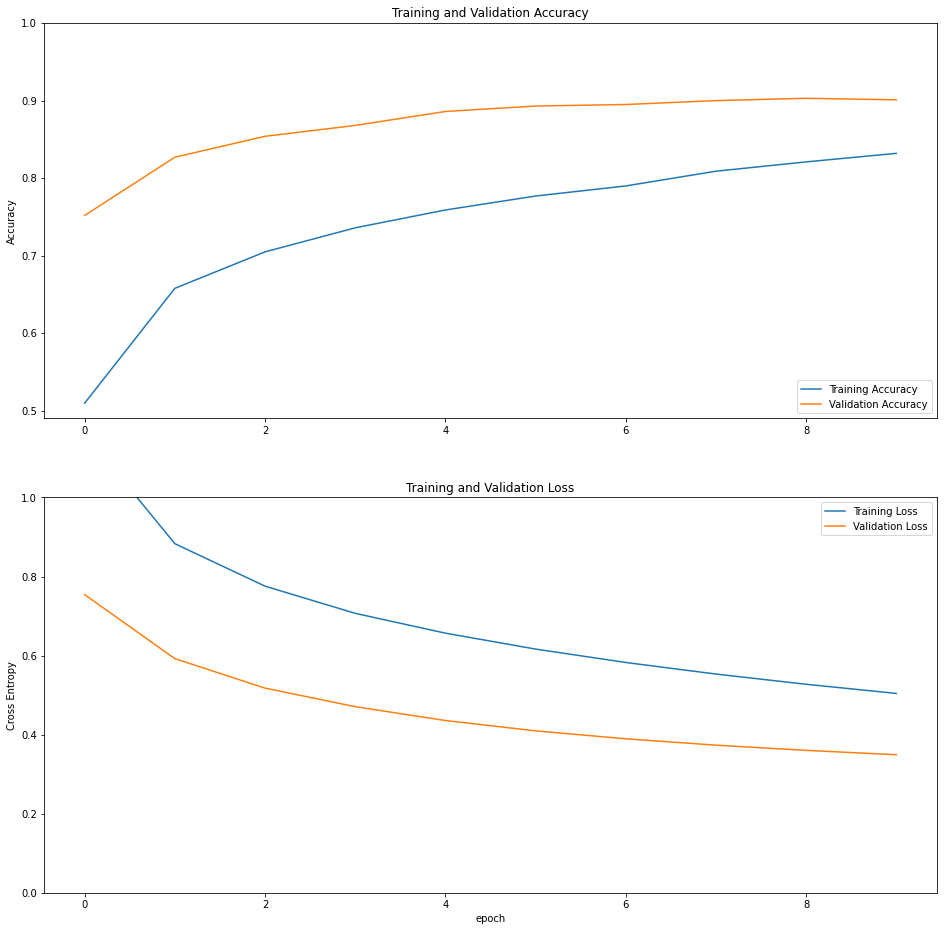

In [ ]:
# plot learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(validation_data)
print('Validation accuracy :', accuracy)

32/32 [==============================] - 2s 75ms/step - loss: 0.3493 - accuracy: 0.9010
Validation accuracy : 0.9010000228881836


After only 10 epochs, validation accuracy is 90%. 

In [ ]:
!cd drive/MyDrive/Colab\ Notebooks/models

In [ ]:
model.save('light-inceptionv3-model')

INFO:tensorflow:Assets written to: light-inceptionv3-model/assets


In [ ]:
def calculate_cm():
# Retrieve a batch of images from the validation set
    image_batch, label_batch = validation_data.as_numpy_iterator().next() 
  
    predictions = np.array([np.argmax(i) for i in predictions])
    label_batch = np.array([np.argmax(i) for i in label_batch])  
    cm = confusion_matrix(label_batch, predictions)
    return cm

cm = calculate_cm()

In [27]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: classes such as [0, 1, 2, 3]                  

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



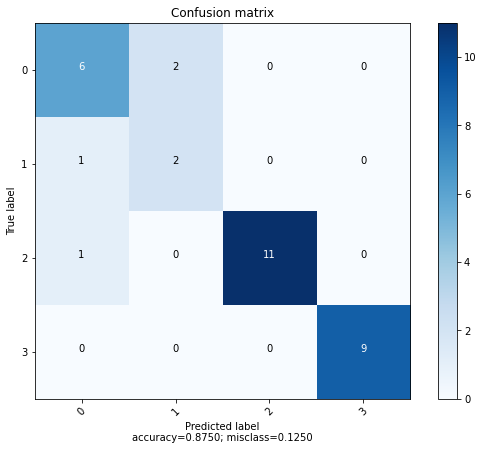

In [28]:
plot_confusion_matrix(cm,
                          target_names=[0,1,2,3],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

In [ ]:
# move sampled files back to their respective directories
cleanup_classes()

Cleaning up CNV
Cleaning up DRUSEN
Cleaning up NORMAL
Cleaning up DME
Cleanup completed
